# CanESM5 GMD paper Figure 23
## ENSO variability and teleconnections


ashao: Initial setup without using validate for just picontrol

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy import signal
from scipy import stats
from dask.diagnostics import ProgressBar
import numpy as np
import sys
from eofs.xarray import Eof
import cftime
from scipy.optimize import curve_fit

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# Load data and ocean grid
datapath = 'input_data/CanESM5_cmip_dir/'
expinfo = {
     
            'historical':
            {
                'realizations' :  ['r{}i1p1f1'.format(num) for num in range(1,11)],
                'years'        :  ['185001-201412']
            }    
}

tos = {}
tas = {}
for expname, info in expinfo.items():
    tos_string = datapath+'{expname}/{realization}/Omon/tos/gn/v20190429/tos_Omon_CanESM5_{expname}_{realization}_gn_{years}.nc'
    tas_string = datapath+'{expname}/{realization}/Amon/tas/gn/v20190429/tas_Amon_CanESM5_{expname}_{realization}_gn_{years}.nc'
    tosfiles = [tos_string.format(expname=expname,realization='{realization}',years=years) for years in info['years']]    
    tasfiles = [tas_string.format(expname=expname,realization='{realization}',years=years) for years in info['years']]    
    tos[expname] = { realization:xr.open_mfdataset( [file.format(realization=realization) for file in tosfiles],use_cftime=True).load()['tos'] for realization in info['realizations'] }
    tas[expname] = { realization:xr.open_mfdataset( [file.format(realization=realization) for file in tasfiles],use_cftime=True).load()['tas'] for realization in info['realizations'] }
    
nemo_grid = xr.open_dataset('input_data/nemo_grid')
nemo_grid = nemo_grid.squeeze().rename( {'x':'i','y':'j'})
# Calculate area
area = (nemo_grid.e1t*nemo_grid.e2t)[1:,1:-1]

In [3]:
## Compute the NINO34 experiment for all requested CanESM5 simulations
# Define the bounds for the NINO34 region
latbounds = np.array([-5,5])
lonbounds = np.mod([-170,-120],360)

nino34 = {}
nino34_monclim = {}
nino34_monstd = {}
for expname, exp in tos.items():
    nino34[expname] = {}
    nino34_monclim[expname] = {}
    nino34_monstd[expname] = {}
    for realization, data in exp.items():
        lat = data.latitude
        lon = data.longitude
        inbounds_lat = xr.ufuncs.logical_and(lat>=latbounds.min(),lat<=latbounds.max())
        inbounds_lon = xr.ufuncs.logical_and(lon>=lonbounds.min(),lon<=lonbounds.max())
        subset_data = data.where(inbounds_lat & inbounds_lon,drop=True)
        mon_group = subset_data.groupby('time.month').mean('time')
        subset_data = subset_data.groupby('time.month') - mon_group
        subset_area = area.where(inbounds_lat & inbounds_lon,drop=True)
        subset_area = subset_area/subset_area.sum()
        
        nino34_monclim[expname][realization] = (mon_group*subset_area).sum(['i','j']).compute()
        nino34[expname][realization] = (subset_data*subset_area).sum(['i','j']).compute()
        nino34_monstd[expname][realization] = nino34[expname][realization].groupby('time.month').std('time')


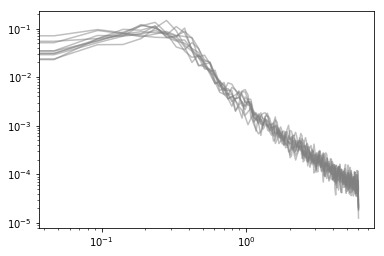

In [4]:
for realization, data in nino34['historical'].items():    
    f,Pxx = signal.welch(data,nperseg=256,scaling='spectrum',fs=12)
    plt.loglog(f,Pxx,label='historical',color='gray',alpha=0.5);


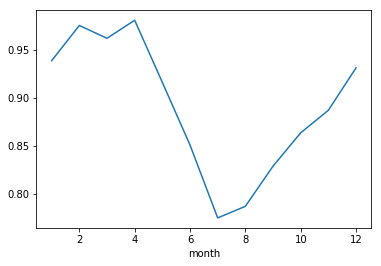

In [5]:
ttime = nino34['historical']['r1i1p1f1'].time.to_masked_array()
# plt.plot(cftime.date2num(ttime,'days since 1850-1-1','noleap')[-720:],nino34['historical']['r1i1p1f1'][-720:])


nino34['historical']['r1i1p1f1'][-600:].groupby('time.month').std('time').plot()

In [6]:
# Do the same for HadISST
hadisst = xr.open_dataset('input_data/obs/HadISST_sst.nc',use_cftime=True)
lat = np.array(hadisst.latitude); lon = np.mod(hadisst.longitude,360)

obs = {}
obs['sst'] = hadisst.sel(latitude=slice(5,-5),longitude=slice(-170,-120))
mon_group = obs['sst'].groupby('time.month').mean('time')
obs['sst'] = obs['sst'].groupby('time.month') - mon_group
weights = xr.ufuncs.cos(obs['sst'].latitude*(np.pi/180.))
weights = weights/weights.sum()/len(obs['sst'].longitude)
nino34['obs'] = (obs['sst']*weights).sum(['latitude','longitude'])['sst']
nino34_monclim['obs'] = (mon_group*weights).sum(['latitude','longitude'])['sst']
nino34_monstd['obs'] = nino34['obs'].groupby('time.month').std('time')

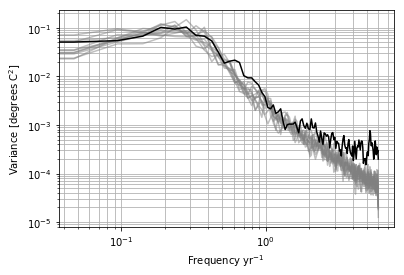

In [7]:
for realization, data in nino34['historical'].items():    
    f,Pxx = signal.welch(data,nperseg=256,scaling='spectrum',fs=12)
    plt.loglog(f,Pxx,label='CanESM5',color='gray',alpha=0.5);
    
f,Pxx = signal.welch(nino34['obs'],nperseg=256,scaling='spectrum',fs=12)    
plt.loglog(f,Pxx,color='black',label='Observed')
plt.grid(which='both'); plt.xlabel('Frequency yr$^{-1}$'); plt.ylabel('Variance [degrees C$^2$]');

In [8]:
def correlation(x,y):
    tau, pval = stats.kendalltau(x,y)
    return tau

def xr_corr_func(field3d,ts,dim='time'):
    field3d = field3d.groupby('time.month') - field3d.groupby('time.month').mean('time')    
    return xr.apply_ufunc(correlation, field3d.chunk((-1,'auto','auto')), ts, input_core_dims = [ ['time'],['time'] ], vectorize=True, output_dtypes = [float], dask='parallelized').compute()

In [9]:
# Calculate the correlation of the index with surface air temperature
tos_corr = {}
for expname, exp in tos.items():
    tos_corr[expname] = {}
    for realization, data in exp.items():        
        if realization == 'r1i1p1f1': tos_corr[expname][realization] = xr_corr_func(data,nino34[expname][realization])
        

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


In [10]:
# Calculate the correlation pattern for the obs
tos_corr['obs'] = xr_corr_func(hadisst['sst'],nino34['obs'])

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


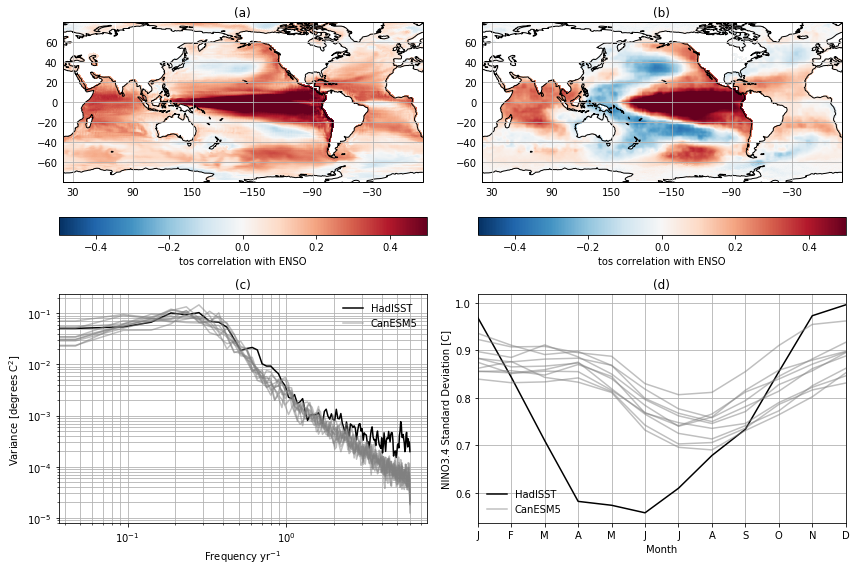

In [11]:
data = tos_corr['historical']['r1i1p1f1']
lat = tos_corr['historical']['r1i1p1f1'].latitude
lon = tos_corr['historical']['r1i1p1f1'].longitude

plt.figure(figsize=(12,8))
ax = plt.subplot2grid((2, 2), (0, 0),projection=ccrs.PlateCarree(central_longitude=200))
im = ax.pcolormesh(np.mod(lon,360),lat,tos_corr['historical']['r1i1p1f1'],cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree(),
                   vmin=-0.5,vmax=0.5, rasterized=True); 
plt.colorbar(im,ax=ax,orientation='horizontal',label='tos correlation with ENSO')
ax.set_extent([-180,180,-80,80],crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,xlocs=range(-210,211,60),ylocs=range(-80,81,20));gl.xlabels_top = gl.ylabels_right = False
ax.coastlines()
ax.set_title('(a)')

ax = plt.subplot2grid((2, 2), (0, 1),projection=ccrs.PlateCarree(central_longitude=200))
im = ax.pcolormesh(hadisst.longitude, hadisst.latitude, tos_corr['obs'],cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree(),vmin=-0.5,vmax=0.5
                  , rasterized=True); 
plt.colorbar(im,ax=ax,orientation='horizontal',label='tos correlation with ENSO')
gl = ax.gridlines(draw_labels=True,xlocs=range(-210,211,60),ylocs=range(-80,81,20)); gl.xlabels_top = gl.ylabels_right = False
ax.set_extent([-180,180,-80,80],crs=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('(b)')

ax = plt.subplot2grid((2, 2), (1, 0))
f,Pxx = signal.welch(nino34['obs'],nperseg=256,scaling='spectrum',fs=12)    
ax.loglog(f,Pxx,color='black',label='HadISST')
for realization, data in nino34['historical'].items():  
    if realization == 'r1i1p1f1':
        label='CanESM5'
    else:
        label=None
    f,Pxx = signal.welch(data,nperseg=256,scaling='spectrum',fs=12)
    ax.loglog(f,Pxx,label=label,color='gray',alpha=0.5);
plt.grid(which='both'); plt.xlabel('Frequency yr$^{-1}$'); plt.ylabel('Variance [degrees C$^2$]');
plt.legend(frameon=False)
ax.set_title('(c)')

ax = plt.subplot2grid((2, 2), (1, 1))
ax.plot(nino34_monstd['obs'],'k',label='HadISST')
for realization in expinfo['historical']['realizations']:
    if realization == 'r1i1p1f1':
        label='CanESM5'
    else:
        label=None
    ax.plot(nino34_monstd['historical'][realization],'gray', alpha=0.5,label=label)
plt.xlim((0,11))
plt.xticks(range(0,12),['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.grid()
ax.set_title('(d)')
plt.xlabel('Month'); plt.ylabel('NINO3.4 Standard Deviation [C]')
plt.legend(frameon=False)

plt.tight_layout()
plt.savefig('plots/fig-23_enso.png', bbox_inches='tight')
plt.savefig('plots/fig-23_enso.pdf', bbox_inches='tight')

In [12]:
### EOFs of SST
hadisst['sst'] = hadisst.sst.where(hadisst.sst != -1000)
mon_anomaly = (hadisst['sst'].groupby('time.month') - hadisst['sst'].groupby('time.month').mean('time'))
coslat = np.cos(np.deg2rad(np.abs(hadisst.coords['latitude'].values)))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(mon_anomaly, weights=wgts)
hadisst['eofs'] = solver.eofsAsCorrelation(neofs=3)

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [13]:
sst = tos['historical']['r1i1p1f1']
mon_anomaly = (sst.groupby('time.month') - sst.groupby('time.month').mean('time'))
solver = Eof(mon_anomaly,weights=area)
tos_eof = solver.eofsAsCorrelation(neofs=3)


/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


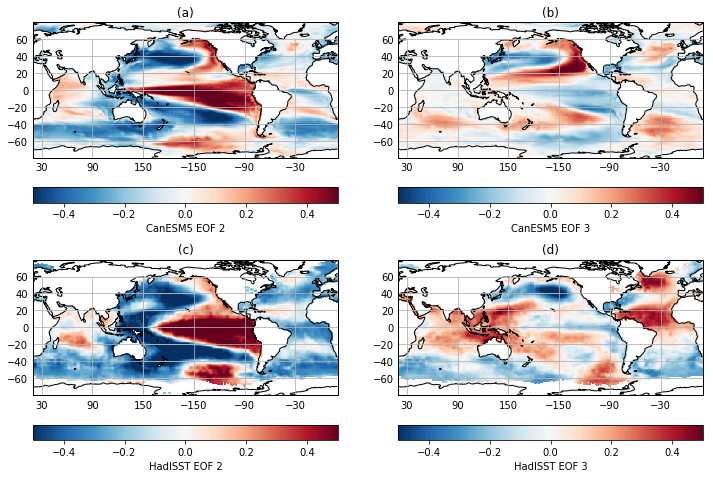

In [14]:
plt.figure(figsize=(12,8))

ax = plt.subplot2grid((2, 2), (0, 1),projection=ccrs.PlateCarree(central_longitude=200))
def plot_eofs(label,title,lon,lat,data,ax):
    ax.pcolormesh(lon,lat,data,vmin=-0.5,vmax=0.5,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
    plt.colorbar(im,ax=ax,orientation='horizontal',label=label)
    ax.set_extent([-180,180,-80,80],crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True,xlocs=range(-210,211,60),ylocs=range(-80,80,20));gl.xlabels_top = gl.ylabels_right = False
    ax.coastlines()
    ax.set_title(title)
    
# Do the HadISST eofs first
lat = tos_eof.latitude ; lon = tos_eof.longitude
ax = plt.subplot2grid((2, 2), (0, 0),projection=ccrs.PlateCarree(central_longitude=200))
plot_eofs('CanESM5 EOF 2','(a)',lon,lat,-tos_eof[1,:,:],ax)
ax = plt.subplot2grid((2, 2), (0, 1),projection=ccrs.PlateCarree(central_longitude=200))
plot_eofs('CanESM5 EOF 3','(b)',lon,lat,tos_eof[2,:,:],ax)

lat = hadisst.latitude ; lon = hadisst.longitude
ax = plt.subplot2grid((2, 2), (1, 0),projection=ccrs.PlateCarree(central_longitude=200))
plot_eofs('HadISST EOF 2','(c)',lon,lat,hadisst['eofs'][1,:,:],ax)
ax = plt.subplot2grid((2, 2), (1, 1),projection=ccrs.PlateCarree(central_longitude=200))
plot_eofs('HadISST EOF 3','(d)',lon,lat,hadisst['eofs'][2,:,:],ax)
plt.savefig('plots/fig-X23_sst_modes.png')

In [15]:
tos_canesm5 = xr.concat( [nino34['historical'][realization] for realization in expinfo['historical']['realizations']], 'ensemble')

In [16]:
ens = (tos_canesm5-tos_canesm5.mean('ensemble'))

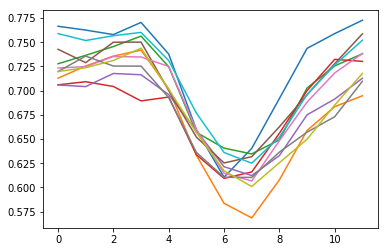

In [17]:
plt.plot(ens.groupby('time.month').std('time').transpose())

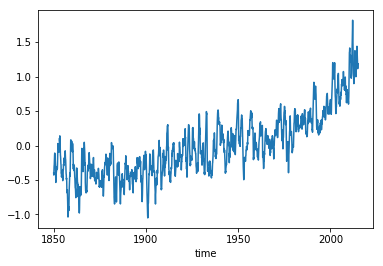

In [18]:
tos_canesm5.mean('ensemble').plot()

In [19]:
def exponential(t, a, b, c):
    return a*np.exp(b*t)+c

In [20]:
scaled_t =  cftime.date2num(tos_canesm5.time,'days since 1850-1-1','noleap')/(365*150)
params = curve_fit(exponential, scaled_t, tos_canesm5.mean('ensemble'))

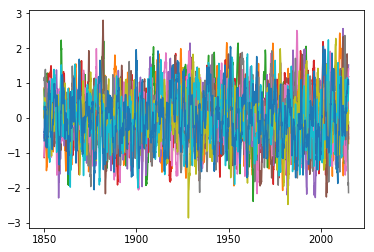

In [21]:
plt.plot(tos_canesm5.time, tos_canesm5.mean('ensemble'))
plt.plot(np.tile(tos_canesm5.time,(10,1)).transpose(), (tos_canesm5 - np.tile(exponential(scaled_t, *params[0]),(10,1))).transpose())

In [22]:
detrended = (tos_canesm5 - np.tile(exponential(scaled_t, *params[0]),(10,1)))

NameError: name 'scaled_t_obs' is not defined

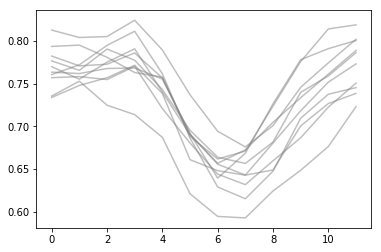

In [23]:
plt.plot(detrended.groupby('time.month').std('time').transpose(),color='gray',alpha=0.5)
plt.plot((nino34['obs']-exponential(scaled_t_obs,*params[0])).groupby('time.month').std('time'))

In [ ]:
scaled_t_obs = cftime.date2num(nino34['obs'].time,'days since 1850-1-1')/(365*150)

In [ ]:
detrended.groupby('time.month').std('time').plot()

In [ ]:
detrended.groupby('time.month').month